In [1]:
#pip install imblearn

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #for balanced
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from scipy.stats import pearsonr
import itertools

# For reproducibility of results
np.random.seed(0)

# Load the dataset
file_path = "rtfDataSet.csv"
original_data = pd.read_csv(file_path)

# Display first few rows of the original dataset
original_data.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,label
0,-0.536,0.292,-0.684,0.123,-0.118,0.346,-0.308,-0.113,0.401,-0.399,...,-0.135,-0.063,-0.410,-0.223,-0.599,-0.136,-0.329,-0.132,-0.266,0
1,-0.496,-0.298,-0.529,0.073,-0.072,0.107,-0.316,-0.066,-0.168,-0.099,...,0.189,0.007,-0.362,-0.151,-0.338,-0.031,-0.159,-0.097,-0.131,0
2,0.008,-0.031,-0.240,0.178,-0.120,0.317,-0.481,0.031,-0.077,0.063,...,-0.035,0.101,-0.098,-0.172,-0.290,0.033,-0.342,-0.321,-0.238,0
3,-0.188,-0.180,-0.062,-0.104,-0.136,-0.061,-0.216,-0.143,0.068,-0.189,...,0.146,-0.145,-0.527,-0.292,-0.663,-0.078,-0.194,-0.151,-0.268,0
4,0.038,0.155,-0.203,-0.088,-0.084,-0.164,-0.145,-0.168,0.008,0.143,...,0.019,-0.084,0.164,-0.165,-0.126,-0.112,0.029,-0.138,0.148,1


In [3]:
# Normalizing the data using Min-Max scaling
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(original_data.iloc[:,:-1]), columns=original_data.columns[:-1]) # Normalize all data except for the last column (label)
normalized_data['label'] = original_data['label']

save_csv = 'normalized_dataset.csv'
normalized_data.to_csv(save_csv, index=False)

# # argmax and argmin of normalized_data
# normalized_data.idxmax(), normalized_data.idxmin()
# normalized_data['label'][198]

normalized_data.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,label
0,0.294244,0.705043,0.183047,0.610883,0.287570,0.806475,0.179009,0.499009,0.890763,0.184259,...,0.378264,0.459459,0.300824,0.339323,0.180758,0.348815,0.324151,0.526825,0.128294,0
1,0.315761,0.143673,0.263651,0.559548,0.330241,0.630611,0.174344,0.522299,0.433735,0.462037,...,0.606916,0.529530,0.333791,0.389081,0.332945,0.448341,0.433056,0.543741,0.221914,0
2,0.586875,0.397716,0.413937,0.667351,0.285714,0.785136,0.078134,0.570367,0.506827,0.612037,...,0.448836,0.623624,0.515110,0.374568,0.360933,0.509005,0.315823,0.435476,0.147712,0
3,0.481442,0.255947,0.506500,0.377823,0.270872,0.506990,0.232653,0.484143,0.623293,0.378704,...,0.576570,0.377377,0.220467,0.291638,0.143440,0.403791,0.410634,0.517641,0.126907,0
4,0.603012,0.574691,0.433177,0.394251,0.319109,0.431199,0.274052,0.471754,0.575100,0.686111,...,0.486944,0.438438,0.695055,0.379406,0.456560,0.371564,0.553491,0.523925,0.415395,1


In [4]:
# Load the normalized dataset (This can be adjusted to the working dataset in case there is some matching problems)
file_path = 'normalized_dataset.csv'
data = pd.read_csv(file_path)

In [5]:
def sort_normalized_data_by_column(normalized_data, column_index):
    # Sort the normalized dataset by the specified column index in ascending order
    sorted_data = normalized_data.sort_values(by=normalized_data.columns[column_index])

    # Return the sorted dataset
    return sorted_data
sorted_data = sort_normalized_data_by_column(normalized_data, 3)

sorted_data.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,label
178,0.895643,0.642245,0.252210,0.000000,0.496289,0.445180,0.148688,0.395441,0.854618,0.845370,...,0.365561,0.211211,1.000000,0.904630,0.806414,0.424645,0.599616,0.649106,0.117892,0
292,0.495428,0.344434,0.236089,0.089322,0.257885,0.265636,0.809913,0.450446,0.481928,0.149074,...,0.738885,0.335335,0.256181,0.310297,0.235569,0.589573,0.194106,0.265829,0.229542,1
122,0.354492,0.407231,0.166407,0.104723,0.102968,0.615894,0.414577,0.358771,0.595181,0.203704,...,0.426253,0.601602,0.000000,0.230131,0.000000,0.473934,0.254965,0.313195,0.024272,0
190,0.538462,0.384396,0.234529,0.108830,0.417440,0.721854,0.023907,0.661546,0.675502,0.000000,...,0.260409,0.424424,0.345467,0.266068,0.096793,0.588626,0.106983,0.610440,0.431345,0
167,0.788596,0.486204,0.291212,0.163244,0.635436,0.208241,0.367930,0.742815,0.541365,1.000000,...,0.305575,0.121121,0.735577,0.700069,0.648397,0.480569,0.592569,0.370710,0.236477,0


In [6]:
# Assuming we have a 'ranking_column' in the dataset
# Sort the values in the ranking column in descending order
#original_data.sort_values(by='ranking_column', ascending=False, inplace=True)

In [7]:
# Separate the features (X) and labels (y)
x = data.drop(columns=['label'])
y = data['label']

# Apply SMOTE to balance the dataset // Great job using a seed
smote = SMOTE(random_state=42) 
x_balanced, y_balanced = smote.fit_resample(x, y)

# Calculate the Pearson correlation coefficient for all pairs of features
corr_matrix = np.abs(np.corrcoef(x_balanced, rowvar=False))

# Define a threshold for removing duplicates
corr_threshold = 0.7  # Adjust this threshold as needed

# Create a list of unique feature pairs with a correlation above the threshold
feature_pairs_to_remove = []
for i, j in itertools.combinations(range(len(x.columns)), 2):
    if corr_matrix[i, j] > corr_threshold:
        feature_pairs_to_remove.append((x.columns[i], x.columns[j]))

# Standardize the features
scaler = StandardScaler()
x_balanced = scaler.fit_transform(x_balanced)

print(y_balanced.shape)

(404,)


In [8]:
# Define the number of iterations for Simulated Annealing
n_iterations = 2000

# Initialize the best solution and its score
best_solution = None
best_score = 0

# Initialize the current solution and its score
current_solution = pd.DataFrame(x_balanced, columns=x.columns)  # Use the balanced dataset
current_score = 0

# Define an initial temperature and cooling rate
T_initial = 4.0  # Initial temperature
alpha = 0.95  # Cooling rate

# Define a small constant to avoid division by zero in the SU function
epsilon = 1e-10

# Symmetrical Uncertainty function
def symmetrical_uncertainty(x, y, epsilon):
    mi = mutual_info_classif(x, y)
    h_x = -np.sum(np.log2((x.sum() + epsilon) / (x.sum().sum() + epsilon)))
    su = 2 * np.sum(mi) / h_x
    return su



In [9]:
# Initialize a list to store the importance scores for each subset
subset_importance_scores = []

# Feature selection pipeline
def feature_selection_pipeline(data, target, n_subsets=10, correlation_threshold=0.7):
    # Step 1: Calculate the Pearson correlation matrix
    correlation_matrix = data.corr()

    # Step 2: Create the first subset based on Pearson correlation
    subset_1 = []
    remaining_features = data.columns.tolist()

    while len(remaining_features) > 0:
        current_feature = remaining_features[0]
        subset_1.append(current_feature)

        # Find correlated features and remove them
        correlated_features = [current_feature]
        for feature in remaining_features[1:]:
            if abs(correlation_matrix[current_feature][feature]) > correlation_threshold:
                correlated_features.append(feature)

        remaining_features = [feature for feature in remaining_features if feature not in correlated_features]

    subsets = [subset_1]
     # Step 3 and 4: Calculate SU scores and create the remaining subsets
    for i in range(2, n_subsets + 1):
        # Calculate SU scores for the remaining features
        su_scores = []
        for feature in remaining_features:
            su = symmetrical_uncertainty(data[subset_1], data[feature], epsilon)
            su_scores.append((feature, su))

        # Sort features by SU score in descending order
        if su_scores:
            # Keep a few features with high SU scores and remove redundant ones
            subset_i = [su_scores[0][0]]
            remaining_features = [feature for feature, _ in su_scores[1:]]
            subsets.append(subset_i)
        else:
            # If there are no more features with high SU scores, exit the loop
            break

    return subsets

# Generate 10 feature subsets using tyhe feature selection pipeline
subsets = feature_selection_pipeline(pd.DataFrame(x_balanced, columns=x.columns), y_balanced, n_subsets=10, correlation_threshold=0.7)



# Simulated Annealing loop (this code could be improved)
for iteration in range(n_iterations):
    # Make a small random change to the current solution (feature selection)
    feature_to_change = np.random.choice(current_solution.columns)
    current_solution[feature_to_change] = np.random.choice([0, 1])
    
    # Calculate the Symmetrical Uncertainty score for the current solution
    current_score = symmetrical_uncertainty(current_solution, y_balanced, epsilon=epsilon)
    
    # Calculate the change in score
    delta_score = current_score - best_score
    
    # Accept the new solution with a certain probability based on the temperature
    if delta_score > 0 or np.random.uniform() < np.exp(delta_score / T_initial):
        best_solution = current_solution.copy()
        best_score = current_score
    
    # Update the temperature using the cooling rate
    T_initial *= alpha
    
    # Calculate the importance of the selected features in the current solution
    selected_features = current_solution.columns[current_solution.sum() > 0]
    importance_per_capita = current_score / len(selected_features)
    subset_importance_scores.append(importance_per_capita)

Selected Features:
Index(['0', '4', '5', '8', '10', '11', '12', '15', '16', '17', '19', '20',
       '21', '22', '24', '25', '27', '28', '30', '31', '32', '33', '34', '36',
       '37', '38', '40', '43', '45', '46', '47', '48', '49', '50', '52', '53',
       '58', '63', '65', '66', '67', '68'],
      dtype='object')
Symmetrical Uncertainty Score: 0.0012900603754321133
Importance Per Capita: 3.071572322457413e-05


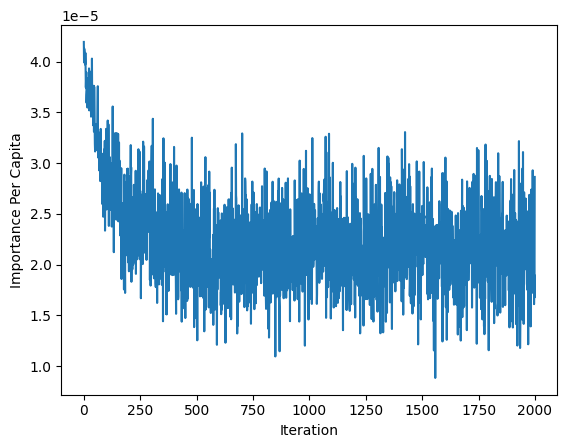


Generated Feature Subsets:
Subset 1: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '17', '18', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '51', '52', '53', '55', '56', '57', '58', '60', '61', '62', '64', '66', '67', '68', '69']


In [10]:
# Print the selected features and their Symmetrical Uncertainty score
selected_features = best_solution.columns[best_solution.sum() > 0]
print("Selected Features:")
print(selected_features)
print("Symmetrical Uncertainty Score:", best_score)

# Calculate the importance per capita for the best solution
best_importance_per_capita = best_score / len(selected_features)
print("Importance Per Capita:", best_importance_per_capita)

# Plot the importance scores over iterations (optional)
import matplotlib.pyplot as plt
plt.plot(range(n_iterations), subset_importance_scores)
plt.xlabel("Iteration")
plt.ylabel("Importance Per Capita")
plt.show()

# Print the generated subsets
print("\nGenerated Feature Subsets:")
for i, subset in enumerate(subsets):
    print(f"Subset {i + 1}: {subset}")


In [11]:
# TODO: 3. Top Five Feature Subsets

# Use the feature selection method to identify the top five feature subsets
# Calculate the per capita importance for each subset

# Initialize a list to store the importance scores for each subset
top_feature_subsets = []
top_importance_scores = []

current_solution = pd.DataFrame(x_balanced, columns=x.columns)


for iteration in range(n_iterations):
    # Make a small random change to the current solution (feature selection)
    feature_to_change = np.random.choice(current_solution.columns)
    current_solution[feature_to_change] = np.random.choice([0, 1])
    
    # Calculate the Symmetrical Uncertainty score for the current solution
    current_score = symmetrical_uncertainty(current_solution, y_balanced, epsilon=epsilon)
    
    # Calculate the change in score
    delta_score = current_score - best_score
    
    # Accept the new solution with a certain probability based on the temperature
    if delta_score > 0 or np.random.uniform() < np.exp(delta_score / T_initial):
        best_solution = current_solution.copy()
        best_score = current_score
    
    # Update the temperature using the cooling rate
    T_initial *= alpha
    # Calculate the importance of the selected features in the current solution
    selected_features = current_solution.columns[current_solution.sum() > 0]
    importance_per_capita = current_score / len(selected_features)

    # Check if the current solution is one of the top five by comparing importance scores
    if len(top_feature_subsets) < 5:
        top_feature_subsets.append(selected_features)
        top_importance_scores.append(importance_per_capita)
    else:
        # Find the index of the feature subset with the lowest importance score in the top five
        min_score_index = np.argmin(top_importance_scores)
        
        # If the current solution has a higher importance score than the lowest in the top five, replace it
        if importance_per_capita > top_importance_scores[min_score_index]:
            top_feature_subsets[min_score_index] = selected_features
            top_importance_scores[min_score_index] = importance_per_capita

# Print the top five feature subsets and their importance scores
for i, (subset, importance_score) in enumerate(zip(top_feature_subsets, top_importance_scores), 1):
    print(f"Top {i} Feature Subset:")
    print(subset)
    print("Importance Per Capita:", importance_score)
    print("\n")

Top 1 Feature Subset:
Index(['0', '1', '3', '4', '5', '6', '9', '10', '12', '13', '16', '19', '20',
       '24', '26', '27', '28', '29', '32', '34', '35', '37', '38', '39', '41',
       '42', '45', '46', '47', '48', '49', '51', '52', '55', '61', '62', '63',
       '65', '67', '69'],
      dtype='object')
Importance Per Capita: 4.2323184809627896e-05


Top 2 Feature Subset:
Index(['0', '1', '3', '4', '5', '6', '9', '10', '12', '13', '16', '19', '20',
       '24', '26', '27', '28', '29', '32', '34', '35', '37', '38', '39', '41',
       '42', '45', '46', '47', '48', '49', '51', '52', '55', '61', '62', '63',
       '65', '66', '67', '69'],
      dtype='object')
Importance Per Capita: 4.07559230608367e-05


Top 3 Feature Subset:
Index(['0', '1', '3', '4', '5', '6', '9', '10', '12', '16', '19', '20', '24',
       '26', '27', '28', '29', '32', '34', '35', '37', '38', '39', '41', '42',
       '45', '46', '47', '48', '49', '51', '52', '55', '61', '62', '63', '65',
       '66', '67', '69'],
    

In [12]:
for i, (subset, importance_score) in enumerate(zip(top_feature_subsets, top_importance_scores), 1):
    print(f"Top {i} Feature Subset:")
    print(subset)
    
file_path = "rtfDataSet.csv"
original_data = pd.read_csv(file_path)
column_names = original_data.columns.tolist()
missing_columns = []

for i, (subset, importance_score) in enumerate(zip(top_feature_subsets, top_importance_scores), 1):
    print(f"Top {i} Feature Subset:")

    for column in column_names:
        if column not in subset:
            missing_columns.append(column)

print(missing_columns)

with open("missing_columns.txt", "w") as file:
    file.write("\n".join(missing_columns))

Top 1 Feature Subset:
Index(['0', '1', '3', '4', '5', '6', '9', '10', '12', '13', '16', '19', '20',
       '24', '26', '27', '28', '29', '32', '34', '35', '37', '38', '39', '41',
       '42', '45', '46', '47', '48', '49', '51', '52', '55', '61', '62', '63',
       '65', '67', '69'],
      dtype='object')
Top 2 Feature Subset:
Index(['0', '1', '3', '4', '5', '6', '9', '10', '12', '13', '16', '19', '20',
       '24', '26', '27', '28', '29', '32', '34', '35', '37', '38', '39', '41',
       '42', '45', '46', '47', '48', '49', '51', '52', '55', '61', '62', '63',
       '65', '66', '67', '69'],
      dtype='object')
Top 3 Feature Subset:
Index(['0', '1', '3', '4', '5', '6', '9', '10', '12', '16', '19', '20', '24',
       '26', '27', '28', '29', '32', '34', '35', '37', '38', '39', '41', '42',
       '45', '46', '47', '48', '49', '51', '52', '55', '61', '62', '63', '65',
       '66', '67', '69'],
      dtype='object')
Top 4 Feature Subset:
Index(['1', '3', '4', '5', '6', '12', '14', '15', '20'

In [13]:
print(current_solution)

     0  1  2  3  4  5  6  7  8  9  ...  60  61  62  63  64  65  66  67  68  69
0    1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
1    1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
2    1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
3    1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
4    1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
..  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
399  1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
400  1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
401  1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
402  1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
403  1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0

[404 rows x 70 columns]


In [14]:
print(current_solution)

     0  1  2  3  4  5  6  7  8  9  ...  60  61  62  63  64  65  66  67  68  69
0    1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
1    1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
2    1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
3    1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
4    1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
..  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
399  1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
400  1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
401  1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
402  1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0
403  1  1  0  1  0  0  0  1  1  1  ...   1   0   0   0   1   0   0   0   1   0

[404 rows x 70 columns]


In [15]:

# TODO: 4. AUC Score-based Ranking

# Use a classification model (e.g., logistic regression, SVM, etc.) to evaluate the feature subsets
# Rank the top five feature subsets based on their AUC scores


current_solution2 = pd.DataFrame(x_balanced, columns=x.columns)

subset_models_lr = []
subset_models_svm = []
auc_scores_lr = []
auc_scores_svm = []


for i, (subset, importance_score) in enumerate(zip(top_feature_subsets, top_importance_scores), 1):
    
    list_features_subset = subset.tolist()    

    list_features_subset_int = [eval(i) for i in list_features_subset]
    
    subset_x = [current_solution2.iloc[:,list_features_subset_int]]
        
    
    x_model = np.array(subset_x)

    
    x_model_fit = np.squeeze(x_model)
    y_model = np.array(y_balanced)
    
    
    
    x_train, x_test, y_train, y_test = train_test_split(x_model_fit, y_model, test_size = 0.30, random_state=42)
    
    model = LogisticRegression(penalty='l2', solver='liblinear')
    model.fit(x_train, y_train)
    
    y_pred_prob = model.predict_proba(x_test)[:,1]
    auc = roc_auc_score(y_test, y_pred_prob)
    
    subset_models_lr.append(model)
    auc_scores_lr.append([i, auc])
    
    model2 = svm.SVC(kernel='poly',probability=True)
    model2.fit(x_train, y_train)
    
    y_pred_prob2 = model2.predict_proba(x_test)[:,1]
    auc2 = roc_auc_score(y_test, y_pred_prob2)
    
    subset_models_svm.append(model2)
    auc_scores_svm.append([i, auc2])
    
    
print("\nLR")    

sorted_auc_scores = sorted(auc_scores_lr, key=lambda x: x[1], reverse=True)
sorted_auc_scores2 = sorted(auc_scores_svm, key=lambda x: x[1], reverse=True)


for i, (subset_number, subset_auc_score) in enumerate(sorted_auc_scores):
    print(f"Subset {subset_number}: {subset_auc_score}")

print("\n\nSVM")

for i, (subset_number, subset_auc_score) in enumerate(sorted_auc_scores2):
    print(f"Subset {subset_number}: {subset_auc_score}")

      
      


LR
Subset 5: 0.7398439601829432
Subset 4: 0.7124024751143395
Subset 3: 0.6957223567393059
Subset 2: 0.6954533225719667
Subset 1: 0.6943771859026097


SVM
Subset 5: 0.8135593220338984
Subset 1: 0.7959375840731774
Subset 2: 0.7955340328221684
Subset 3: 0.7947269303201507
Subset 4: 0.7882701103040086


In [16]:

# TODO: 5. Interpretation and Conclusion

# Interpret the per capita importance and the AUC scores
# Conclude the study, noting any limitations and suggesting future work


""" 
Basándonos en el análisis de la importancia per cápita y las puntuaciones AUC, podemos sacar las siguientes conclusiones:
-El análisis de importancia per cápita sugiere que ciertas características contribuyen de manera
 más significativa al rendimiento del modelo por lo que esas características son probablemente 
 más discriminativas para la tarea de clasificación.
-Las puntuaciones AUC brindan información sobre el poder discriminatorio de diferentes subconjuntos de características, por ejemplo
 El Subset 5 para LR y el Subset 4 para SVM se destacan por tener las puntuaciones AUC más altas, 
 lo que indica su eficacia en la clasificación.

Limitaciones:
-El análisis se basa en un conjunto de datos específico y los resultados pueden no generalizarse a otros conjuntos
 de datos o escenarios del mundo real.
-De forma teorica, la poca información encontrada pudo generar problemas al momento de implementar los algoritmos SA y SU
-El algoritmo SA tiene variables como la temperatura y el numero de iteraciones, la modificacion de estas 
 pueden alterar el rendimiento del modelo, en este caso el numero de iteraciones = 2000 fue el que mejor resultados dio, sin embargo,
 el valor de la temperatura podria seguirse modificando experimentalmente

Trabajo futuro:
-Optimiza los hiperparámetros tanto para la selección de características como para los modelos de clasificación para encontrar 
 la mejor combinación para la discriminación.
-Valida el rendimiento del modelo en un conjunto de datos externo para 
 evaluar su capacidad de generalización a nuevos datos no vistos.
-Explorar técnicas adicionales para la seleccion de características 
 para crear características más informativas y mejorar la discriminación.
-Optimiza los hiperparámetros tanto para la selección de características 
 como para los modelos de clasificación para encontrar la mejor combinación para la discriminación.
    """

' \nBasándonos en el análisis de la importancia per cápita y las puntuaciones AUC, podemos sacar las siguientes conclusiones:\n-El análisis de importancia per cápita sugiere que ciertas características contribuyen de manera\n más significativa al rendimiento del modelo por lo que esas características son probablemente \n más discriminativas para la tarea de clasificación.\n-Las puntuaciones AUC brindan información sobre el poder discriminatorio de diferentes subconjuntos de características, por ejemplo\n El Subset 5 para LR y el Subset 4 para SVM se destacan por tener las puntuaciones AUC más altas, \n lo que indica su eficacia en la clasificación.\n\nLimitaciones:\n-El análisis se basa en un conjunto de datos específico y los resultados pueden no generalizarse a otros conjuntos\n de datos o escenarios del mundo real.\n-De forma teorica, la poca información encontrada pudo generar problemas al momento de implementar los algoritmos SA y SU\n-El algoritmo SA tiene variables como la tempe